# Gaussian Fitting Using Scipy
The MCMC process I previously used is not yielding the best results and the brightnesses I was getting seem entirely incorrect. Because of this, I decided to manually create the Gaussian fit using scipy.optimize.curve_fit() which is much more efficient and gives the correct parameters. Using [Single Gaussian Peak Fitting](https://github.com/emilyripka/BlogRepo/blob/master/181119_PeakFitting.ipynb) by Emily Ripka I was able to use her Gaussian function to fit to the COS data.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import scipy as scipy
from scipy import optimize
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
line = "S I"
target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']

In [4]:
df_wavelength

17    1208.8500
18    1211.2120
19    1211.3800
20    1212.7950
21    1218.5950
22    1224.4240
23    1224.4790
24    1224.5440
26    1227.0890
28    1233.9220
30    1241.9050
31    1247.1600
32    1248.0450
34    1250.8140
35    1253.2970
36    1253.3250
38    1256.0930
41    1262.8600
42    1269.2090
43    1270.7820
44    1277.1990
45    1277.2120
46    1280.0990
47    1295.6520
48    1296.1740
50    1302.3370
51    1302.8630
52    1303.1110
53    1303.4295
55    1305.8830
57    1310.1940
58    1313.2490
59    1316.5420
60    1316.6180
61    1323.5150
62    1323.5220
63    1326.6430
71    1381.5520
72    1385.5100
73    1388.4350
74    1389.1540
77    1392.5880
78    1396.1120
79    1401.5140
82    1409.3370
83    1412.8730
86    1425.0300
87    1425.2190
88    1433.2800
89    1433.3110
90    1436.9680
91    1448.2290
Name: Wavelength, dtype: float64

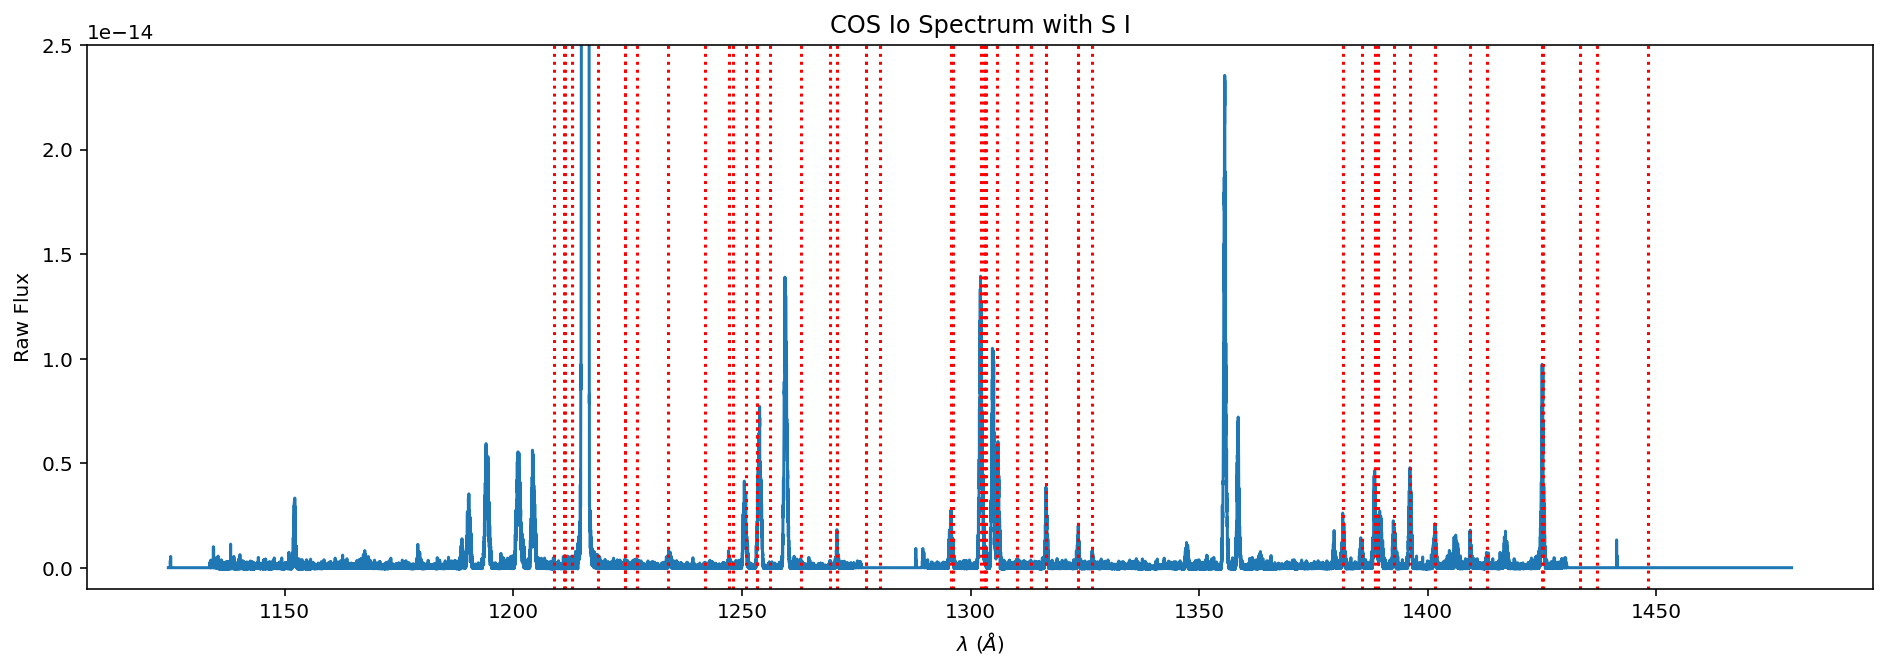

In [5]:
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum with S I")
plt.ylim(-0.01*10**-13,0.25*10**-13)
for xc in df_wavelength:
    plt.axvline(x=xc, color = 'red', linestyle = 'dotted')

(-5e-16, 1.5e-14)

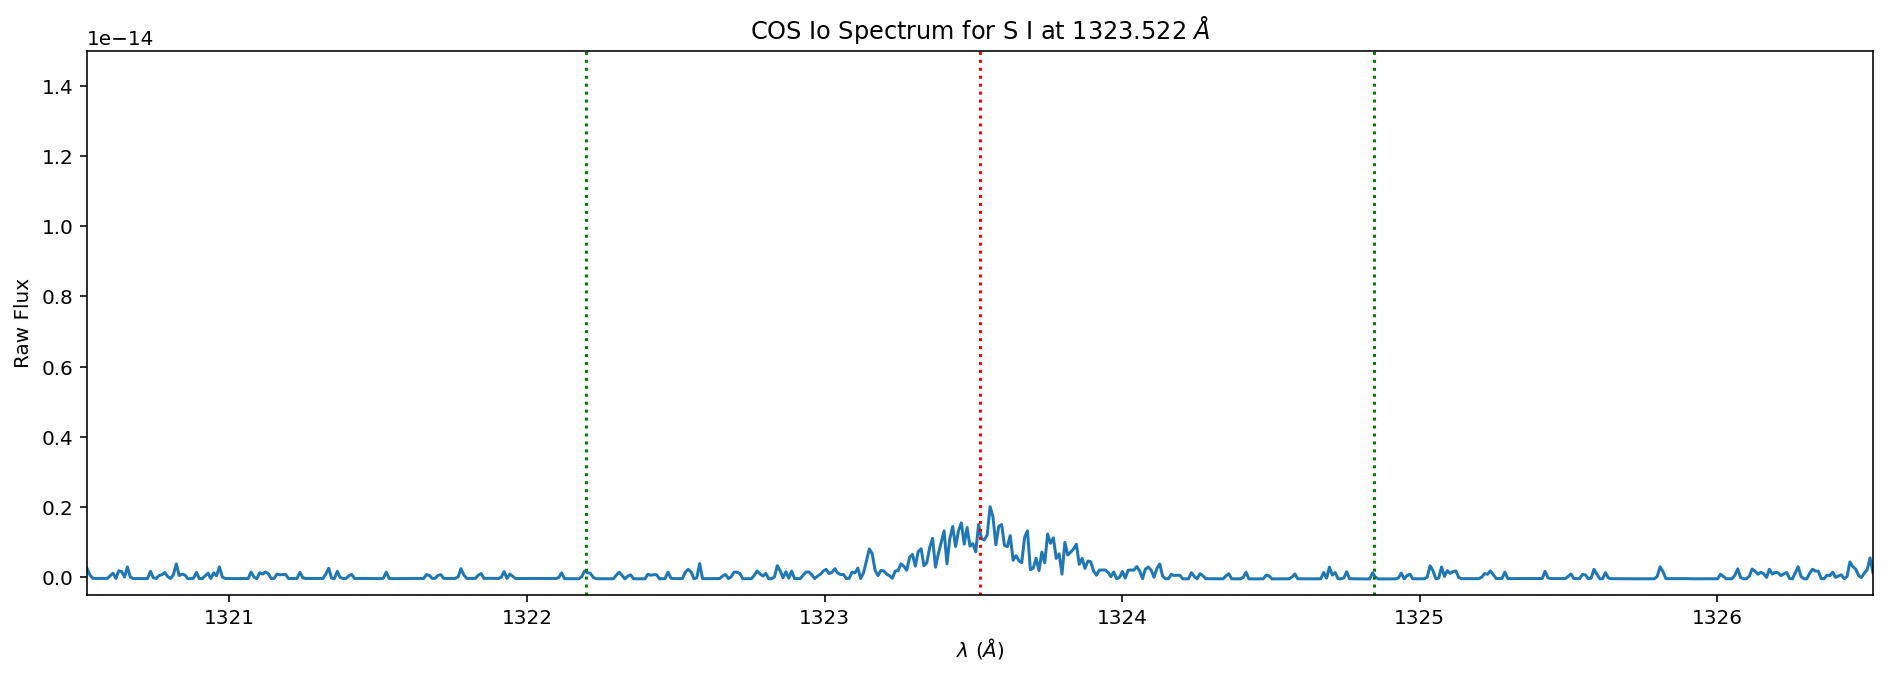

In [7]:
line = 1323.522
left_bound = 0.999*line
right_bound = 1.001*line
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum for S I at {} $\AA$".format(line))
plt.axvline(line, color = 'red', linestyle = 'dotted')
plt.axvline(left_bound, color = 'green', linestyle = 'dotted')
plt.axvline(right_bound, color = 'green', linestyle = 'dotted')
plt.xlim(line-3,line+3)
plt.ylim(-0.005*10**-13,0.15*10**-13)

In [8]:
sub_region = (evt_data['WAVELENGTH'] > left_bound) & (evt_data['WAVELENGTH'] < right_bound) #only take values within this area
wl = evt_data['WAVELENGTH'][sub_region]
flux = evt_data['FLUX'][sub_region]
unc = 0.1*flux #placeholder uncertainty
wl_array = wl.data
flux_array = flux.data


Here we are defining the function to create the Gaussian curve which will fit our data.

In [9]:
def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl_array-cen1)/sigma1)**2)))

(-5e-16, 1.5e-14)

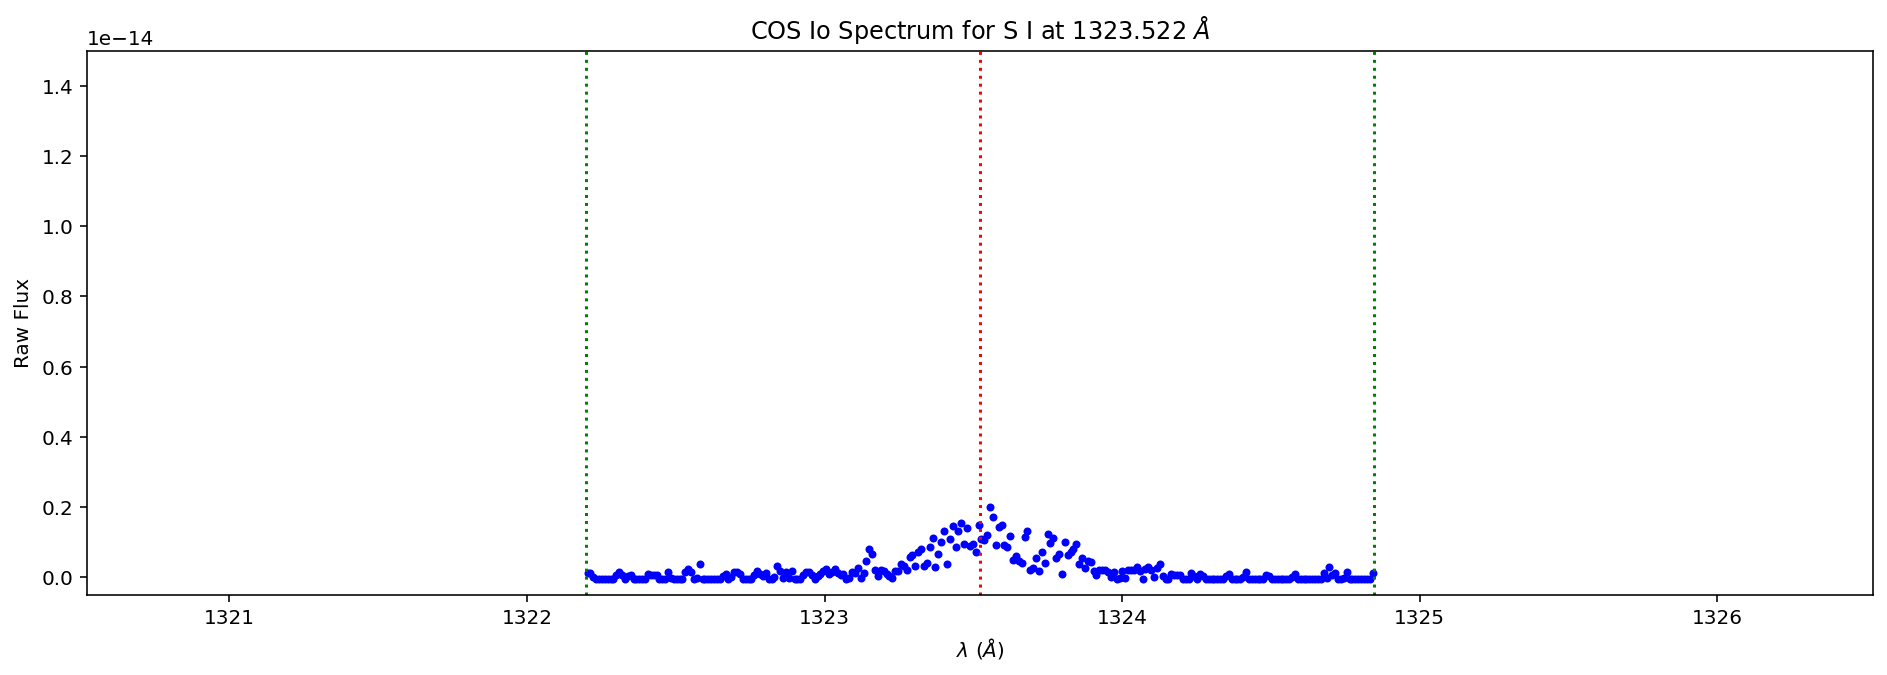

In [10]:
left_bound = 0.999*line
right_bound = 1.001*line
plt.figure(figsize=(16, 5))
plt.plot(wl_array,flux_array,'b.') #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum for S I at {} $\AA$".format(line))
plt.axvline(line, color = 'red', linestyle = 'dotted')
plt.axvline(left_bound, color = 'green', linestyle = 'dotted')
plt.axvline(right_bound, color = 'green', linestyle = 'dotted')
plt.xlim(line-3,line+3)
plt.ylim(-0.005*10**-13,0.15*10**-13)

In [11]:
amp1 = 0.5*10**-14
sigma1 = 1
cen1 = line

In [12]:
popt_gauss, pcov_gauss = scipy.optimize.curve_fit(_1gaussian, wl_array, flux_array, p0=[amp1, cen1, sigma1])

perr_gauss = np.sqrt(np.diag(pcov_gauss))

We will now define the amplitude, center wavelength, and width, and the corresponding errors.

In [13]:
a = popt_gauss[0]
a_err = perr_gauss[0]
mu = popt_gauss[1]
mu_err = perr_gauss[1]
w = popt_gauss[2]
w_err = perr_gauss[2]

In [14]:
print("\ngiven line is = {} ".format(line))
print("amplitude = {} (+/-) {}".format("{:e}".format(a), "{:e}".format(a_err)))
print("mu = {} (+/-) {}".format(mu, "{:e}".format(mu_err)))
print("sigma = {} (+/-) {}".format((w), "{:e}".format(w_err)))


given line is = 1323.522 
amplitude = 5.890302e-16 (+/-) 2.107226e-17
mu = 1323.5479773275947 (+/-) 8.619122e-03
sigma = 0.20865291610871928 (+/-) 8.619122e-03


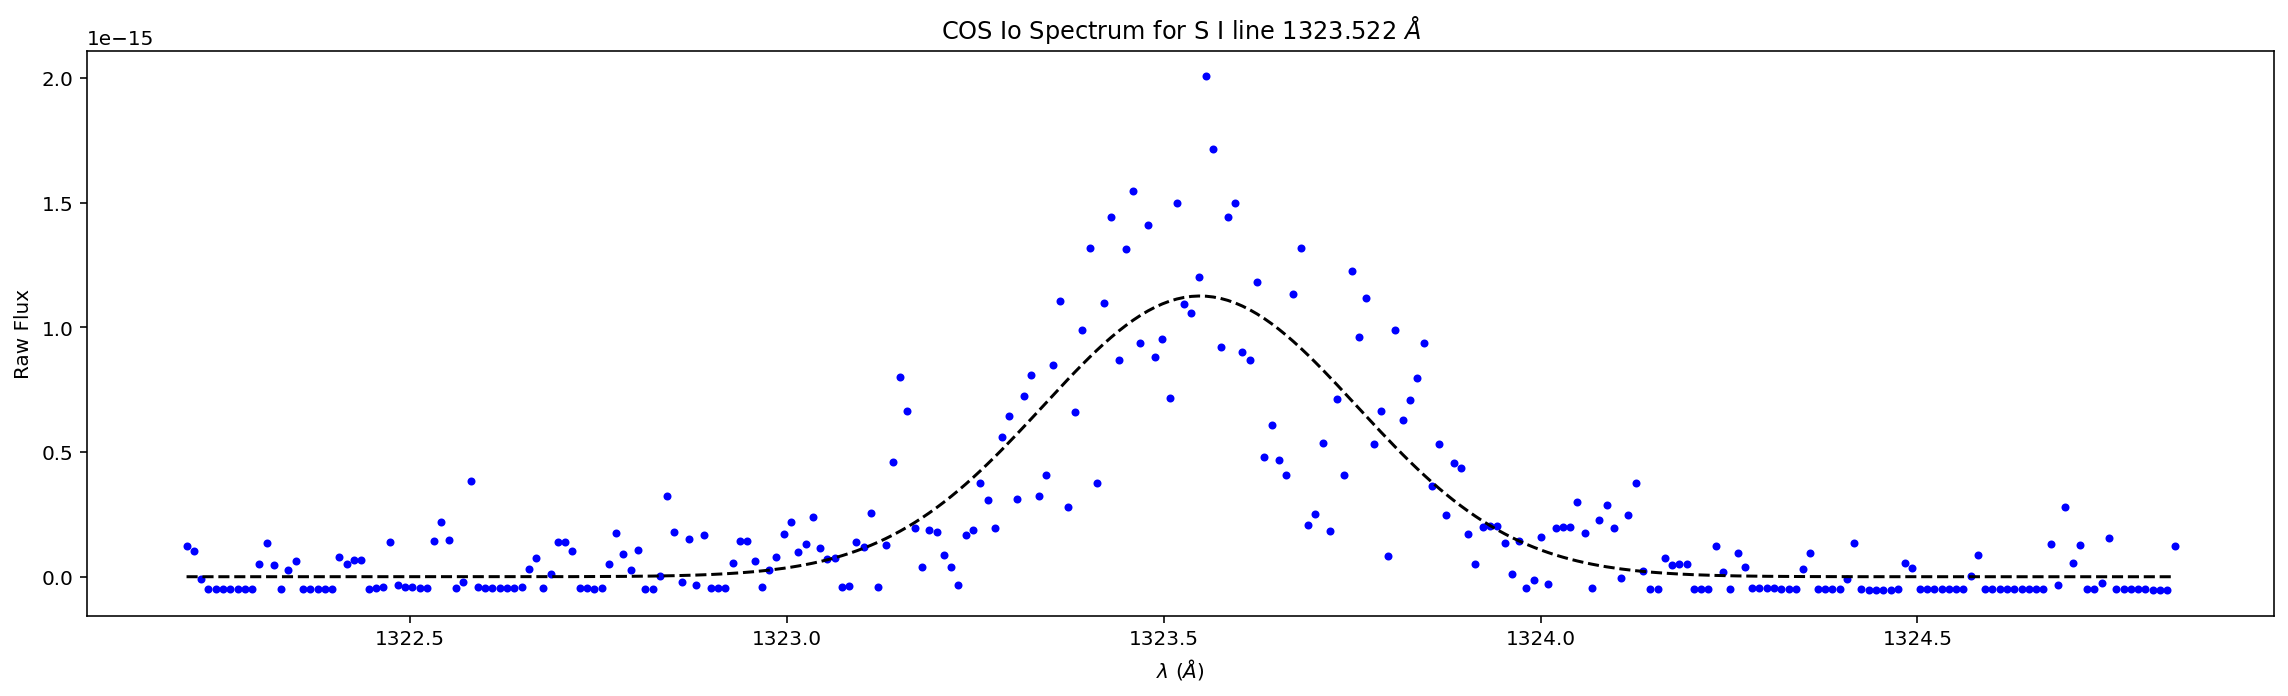

In [15]:
plt.figure(figsize=(16, 5))
plt.plot(wl_array,flux_array,'b.') #make it columns instead of rows bc otherwise will be a blank plot
#plt.ylim(-1*10**-15,1*10**-15)
plt.plot(wl_array, _1gaussian(wl_array, *popt_gauss), 'k--')#,\
#label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum for S I line {} $\AA$".format(line))
plt.tight_layout()
save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/'
plt.savefig(save_place+"gauss_fit_{}.jpg".format(line), format="jpg",dpi=1000)


Now let us calculate the brightness with the given amplitude and width of the curve. The integral of a Gaussian function is given by $$\int_{-\infty}^\infty a\,e^{-\left( x-b \right)^2/2c^2}\,dx=\sqrt{2\pi} a \, \left\vert c \right\vert \, $$ where in this case, $a$ corresponds to the amplitude and $c$ corresponds to the width.

In [57]:
brightness = ((2*np.pi)**.5)*(a*w)
print("The brightness of S I at {} Angstrom is {}.".format(line,brightness))

The brightness of S I at 1303.4295 Angstrom is 2.238288534201102e-14.


Thus, we are able to calculate the brightness of a line!

# Testing

In [ ]:
x_array = np.linspace(1,100,50)

amp1 = 100
sigma1 = 10
cen1 = 50
y_array_gauss = amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2)))

# creating some noise to add the the y-axis data
y_noise_gauss = (np.exp((np.random.ranf(50))))/5
y_array_gauss += y_noise_gauss

In [ ]:
fig = plt.figure(figsize=(4,3))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.plot(x_array, y_array_gauss, "ro")

ax1.set_xlim(-5,105)
ax1.set_ylim(-0.5,5)

ax1.set_xlabel("x_array",family="serif",  fontsize=12)
ax1.set_ylabel("y_array",family="serif",  fontsize=12)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(50))

ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1.tick_params(axis='both',which='major', direction="out", top="on", right="on", bottom="on", length=8, labelsize=8)
ax1.tick_params(axis='both',which='minor', direction="out", top="on", right="on", bottom="on", length=5, labelsize=8)

fig.tight_layout()
fig.savefig("rawGaussian.png", format="png",dpi=1000)

In [ ]:
popt_gauss, pcov_gauss = scipy.optimize.curve_fit(_1gaussian, x_array, y_array_gauss, p0=[amp1, cen1, sigma1])

perr_gauss = np.sqrt(np.diag(pcov_gauss))

In [ ]:
print("amplitude = %0.2f (+/-) %0.2f" % (popt_gauss[0], perr_gauss[0]))
print("center = %0.2f (+/-) %0.2f" % (popt_gauss[1], perr_gauss[1]))
print("sigma = %0.2f (+/-) %0.2f" % (popt_gauss[2], perr_gauss[2]))

In [ ]:
fig = plt.figure(figsize=(4,3))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.plot(x_array, y_array_gauss, "ro")
ax1.plot(x_array, _1gaussian(x_array, *popt_gauss), 'k--')#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

ax1.set_xlim(-5,105)
ax1.set_ylim(-0.5,5)

ax1.set_xlabel("x_array",family="serif",  fontsize=12)
ax1.set_ylabel("y_array",family="serif",  fontsize=12)

ax1.legend(loc="best")

ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(50))

ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1.tick_params(axis='both',which='major', direction="out", top="on", right="on", bottom="on", length=8, labelsize=8)
ax1.tick_params(axis='both',which='minor', direction="out", top="on", right="on", bottom="on", length=5, labelsize=8)

fig.tight_layout()
fig.savefig("fitGaussian.png", format="png",dpi=1000)